In [1]:
%matplotlib inline
from os.path  import join
import Packages.DataLoaders as loader
import random
import matplotlib.pyplot as plt
import numpy as np
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import Packages.model_package as model_package

In [2]:
torch.cuda.is_available()

True

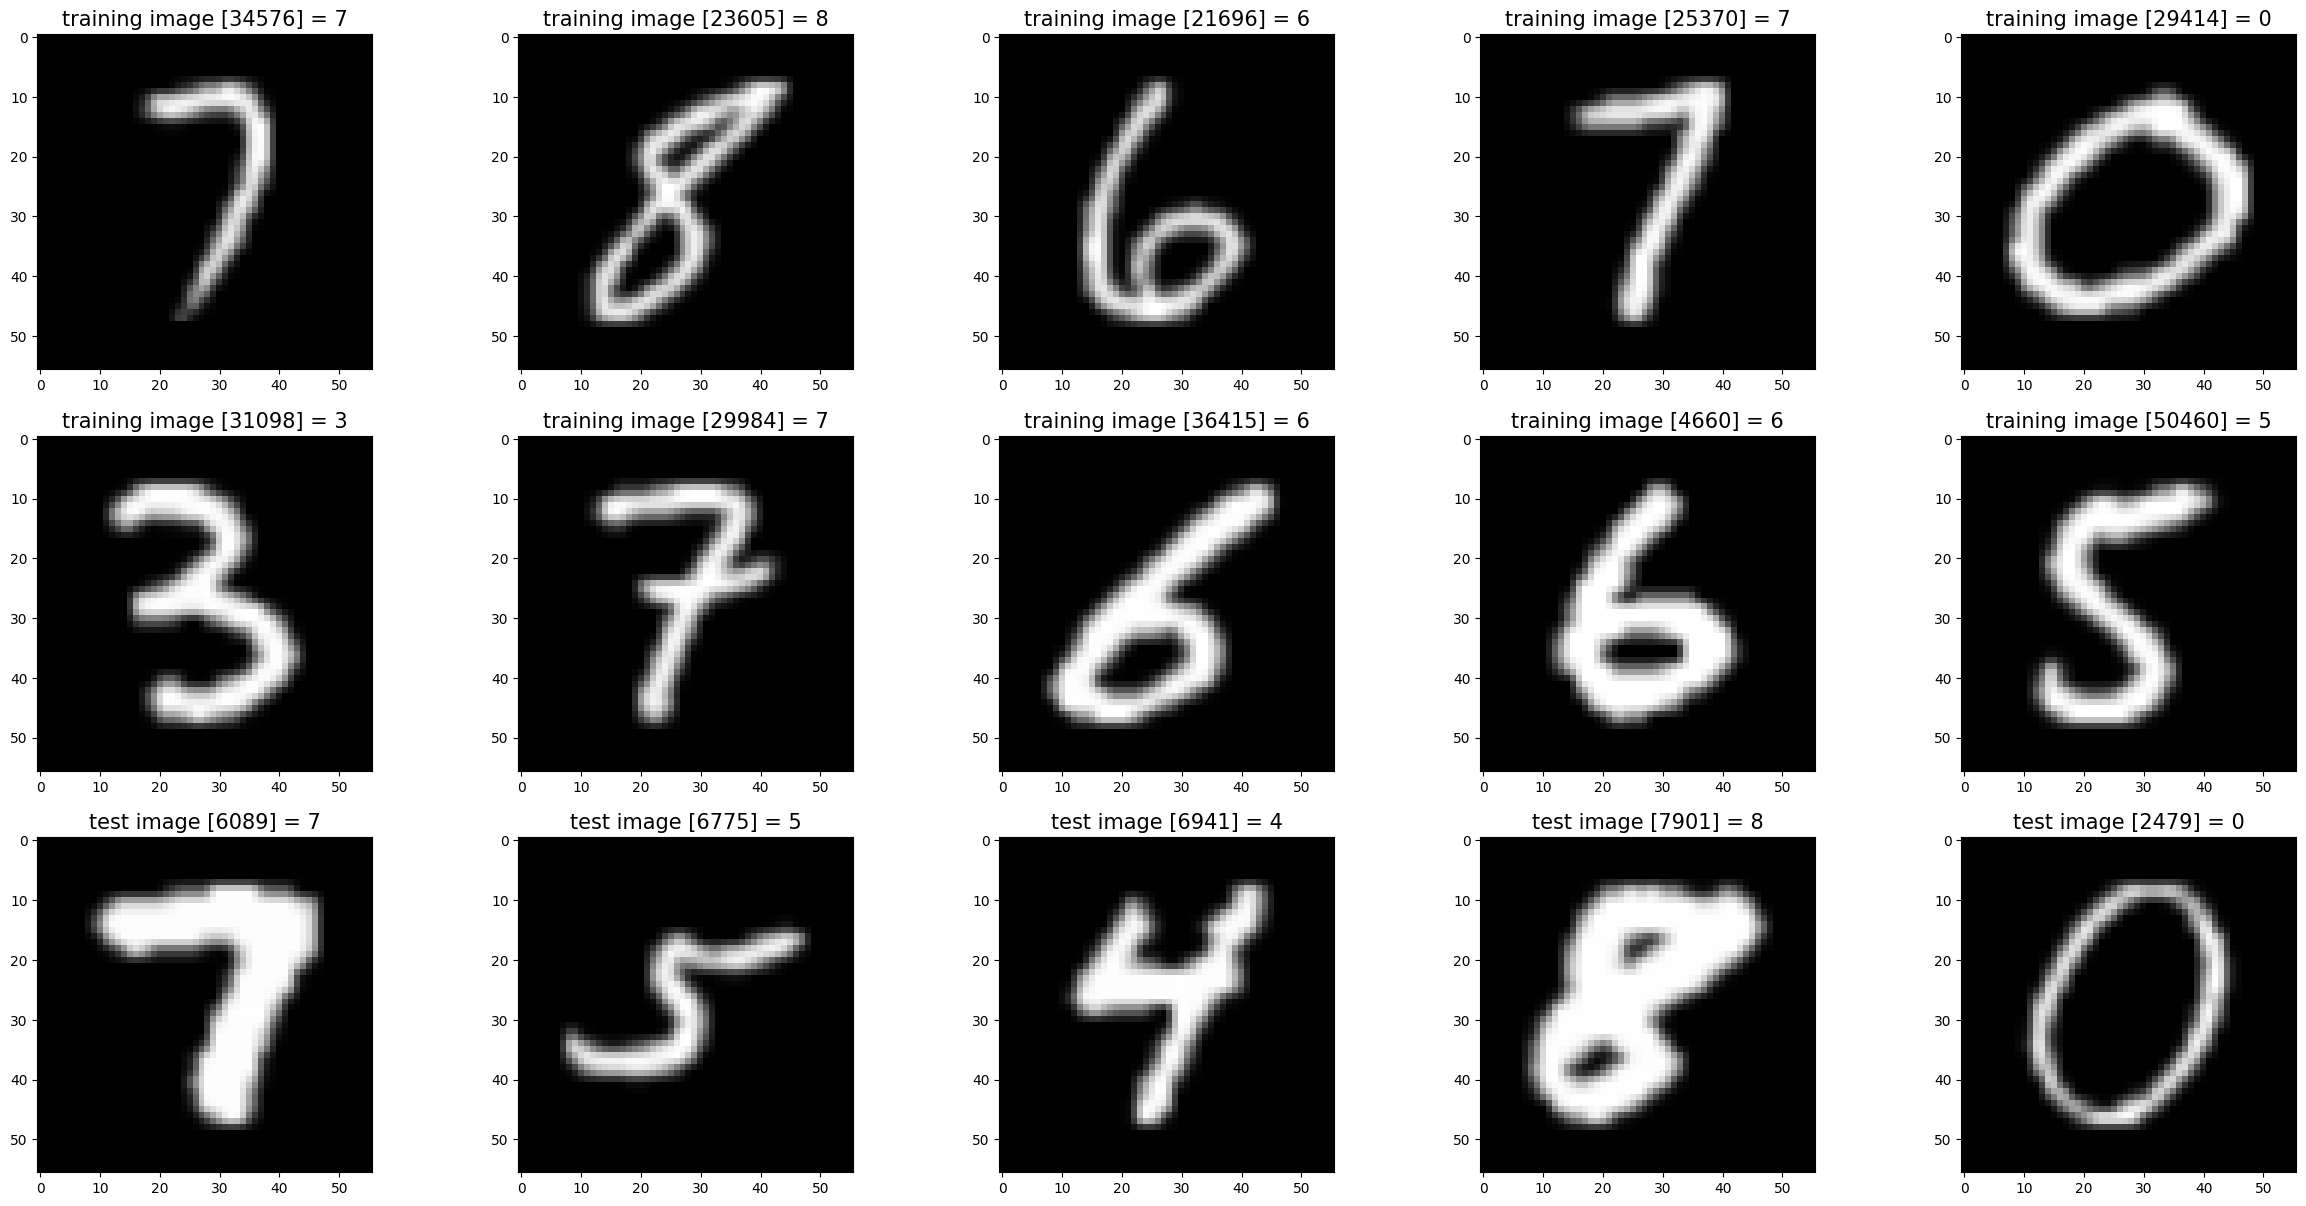

In [3]:

input_path = './Data'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

# Helper function to show a list of images with their relating titles
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

# Load MINST dataset
mnist_dataloader = loader.MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath, width = 56)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data_cropped()
n_train_first = len(x_train)
# Show some random training and test images 
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r])) 

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))

show_images(images_2_show, titles_2_show)

In [4]:
# Train with only digit data for testing purposes
# n_train_first = 0
# x_train = []
# y_train = []

In [5]:
font_loader = loader.FontDigitImageLoader(join(input_path,"Digits"),n = 1, width = 56)

In [6]:
font_images = font_loader.GetImages()
font_labels = font_loader.GetLabels()
x_train.extend(font_images)
y_train.extend(font_labels)

n_train_second = len(x_train)
print(n_train_second)

70160


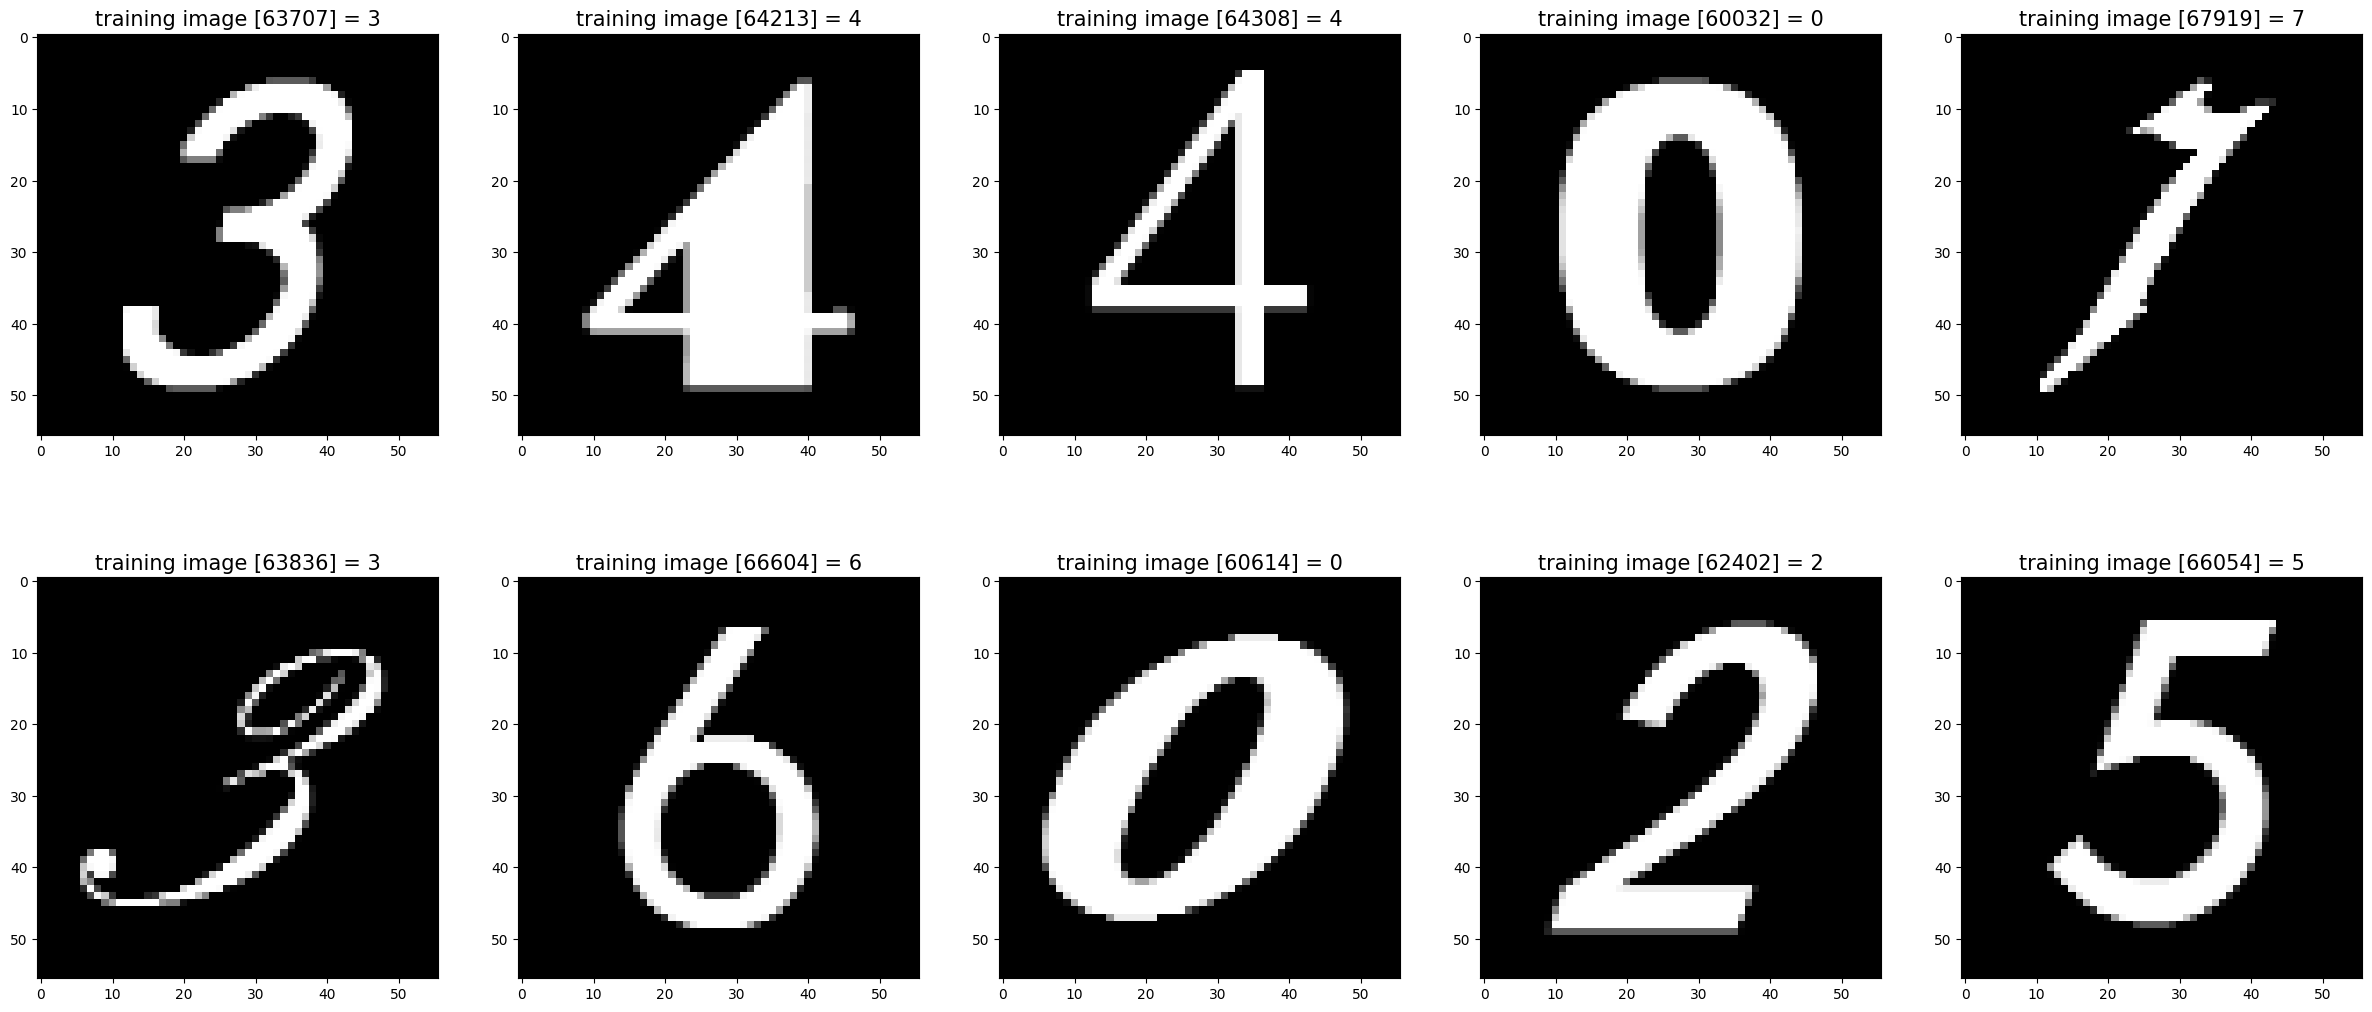

In [7]:
# Show some random font images 
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(n_train_first, n_train_second-1)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r])) 
show_images(images_2_show, titles_2_show)

In [8]:
"""
# Appending an empty image with 10 as label
x_train.append(np.zeros((28,28)))
y_train.append(10)
x_test.append(np.zeros((28,28)))
y_test.append(10)

# Change the weights so that the empty image becomes more important.
w = np.ones(11)
w[-1]=w[-1]*1000
"""
w = np.ones(10)

In [9]:
# Using the sudokus as test data
sudoku_data = []
sudoku_labels = []

# Load the image
processor1 = loader.SudokuImageProcessor(join(input_path, "Sudokus/sudoku1.png"),number_path=join(input_path, "Sudokus/sudoku1.npy"), width = 56)
processor1.create_digits(0.1)
(x1,y1) = processor1.to_test_data()
sudoku_data=sudoku_data+x1
sudoku_labels=sudoku_labels+y1

processor2 = loader.SudokuImageProcessor(join(input_path, "Sudokus/sudoku2.png"),number_path=join(input_path, "Sudokus/sudoku2.npy"), width = 56)
processor2.create_digits(0.1)



(x2,y2) = processor2.to_test_data()
sudoku_data=sudoku_data+x2
sudoku_labels=sudoku_labels+y2

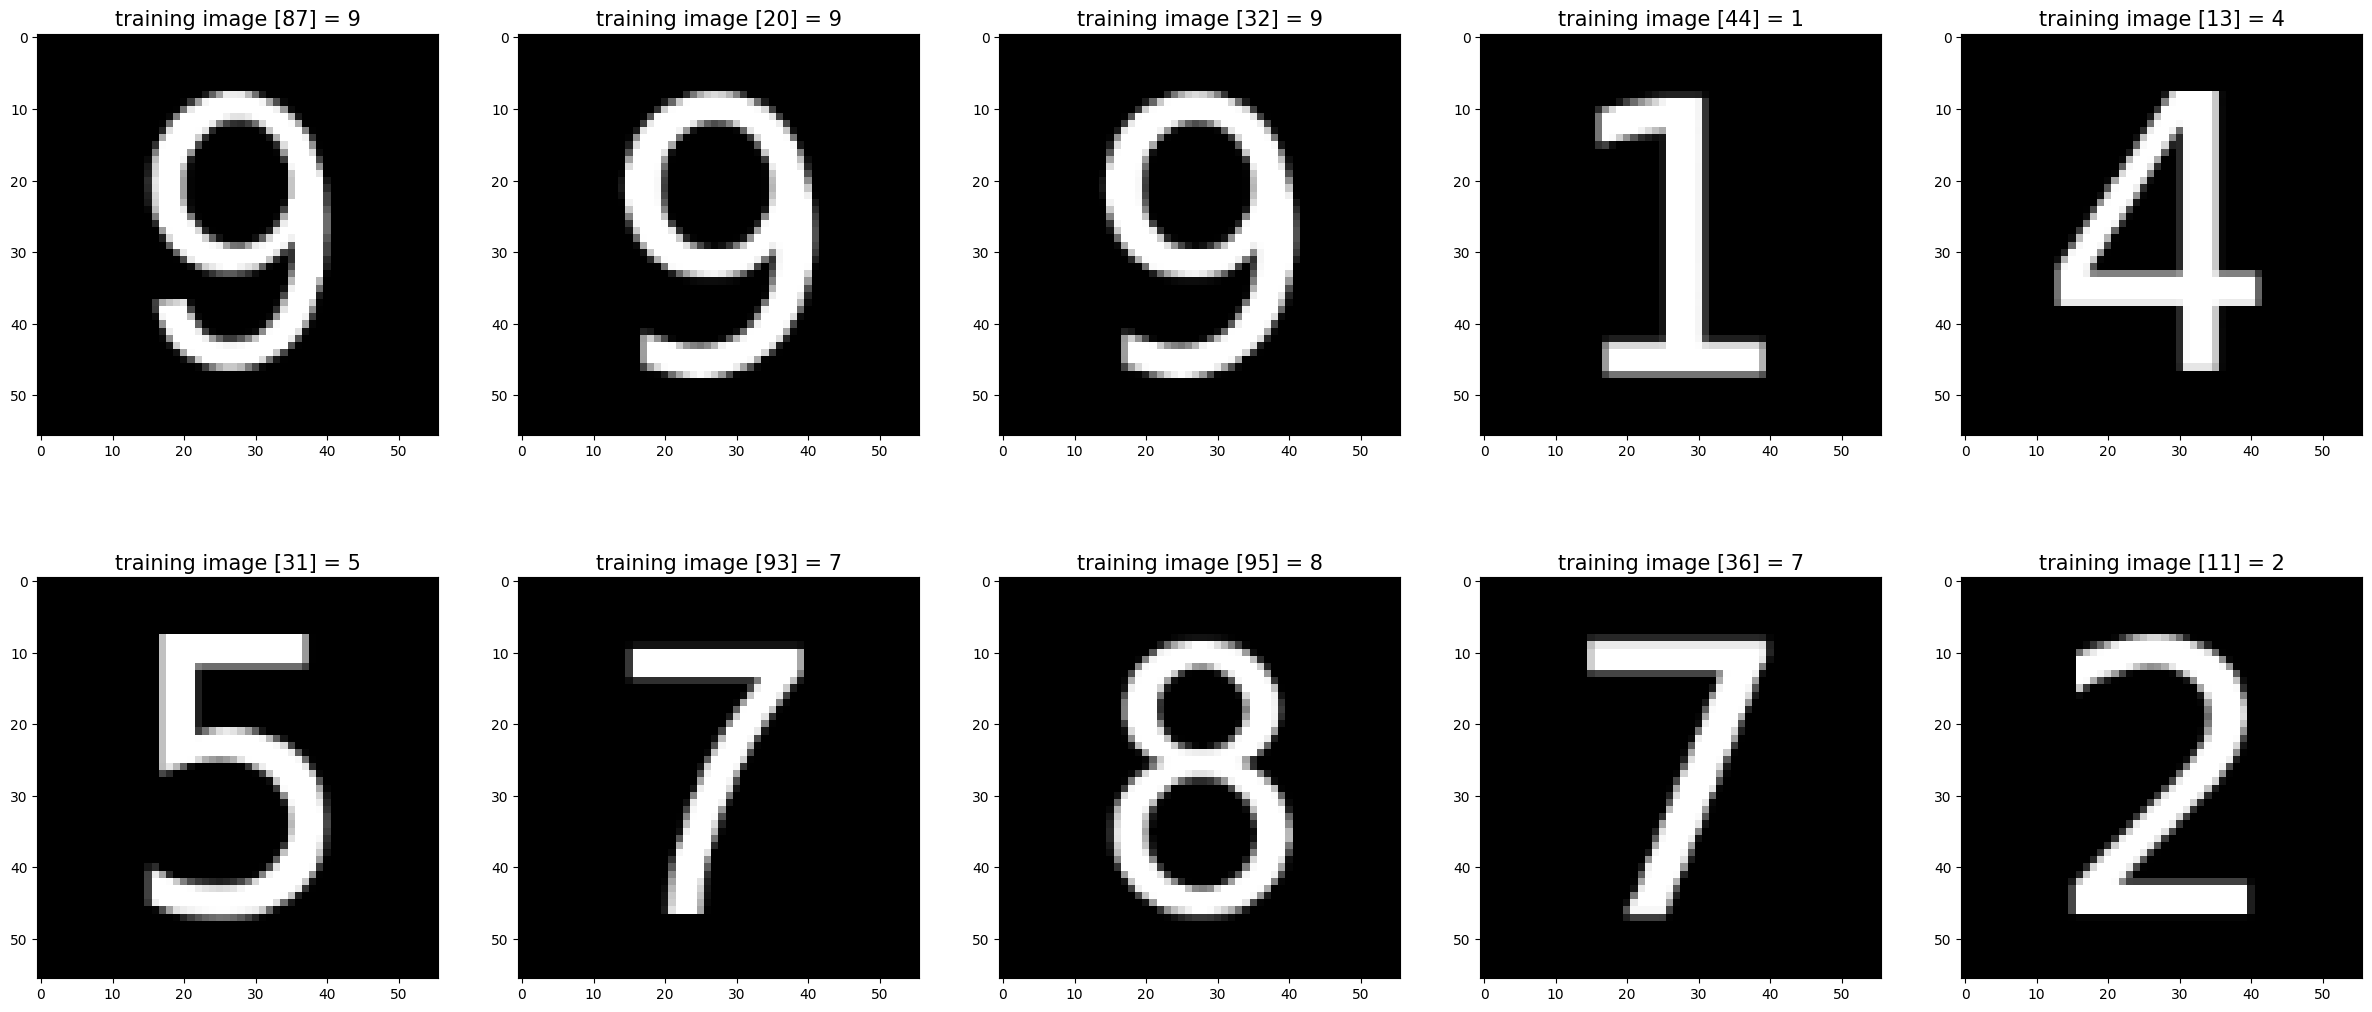

In [10]:
# Show some random sudoku images 
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(0, len(sudoku_data)-1)
    images_2_show.append(sudoku_data[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(sudoku_labels[r])) 
show_images(images_2_show, titles_2_show)

In [11]:
print("Amount of training data: " + str(len(x_train)))
print("Amount testing data: " + str(len(x_test)))
print("Amount of sudoku data: " + str(len(sudoku_data)))

Amount of training data: 70160
Amount testing data: 10000
Amount of sudoku data: 100


In [12]:
trainer = model_package.ModelTrainer(x_train, y_train, x_test, y_test, sudoku_data, sudoku_labels, w)
(score_test,score_sudoku,model) = trainer.OneSeedProgram(7,30,decision_mode = "both",model_mode="ConvolutionalNN", width=56)
torch.save(model.state_dict(), "model")
#model = model_package.ConvolutionalNN()
#model.load_state_dict(torch.load("model"))
#model.eval()

Epoch 1/30, Loss: 0.23674275268314096
Epoch 1/30, Accuracy on the test set: 97.77%
Epoch 1/30, Accuracy on the sudoku set: 100.00%
Epoch 2/30, Loss: 0.05038098272760955
Epoch 2/30, Accuracy on the test set: 98.39%
Epoch 2/30, Accuracy on the sudoku set: 100.00%
Epoch 3/30, Loss: 0.035551268688494654
Epoch 3/30, Accuracy on the test set: 98.74%
Epoch 3/30, Accuracy on the sudoku set: 100.00%
Epoch 4/30, Loss: 0.031111616920833685
Epoch 4/30, Accuracy on the test set: 98.79%
Epoch 4/30, Accuracy on the sudoku set: 100.00%
Epoch 5/30, Loss: 0.02656080858265115
Epoch 5/30, Accuracy on the test set: 98.03%
Epoch 5/30, Accuracy on the sudoku set: 100.00%
Epoch 6/30, Loss: 0.02319427149601903
Epoch 6/30, Accuracy on the test set: 98.46%
Epoch 6/30, Accuracy on the sudoku set: 100.00%
Epoch 7/30, Loss: 0.01973502876941637
Epoch 7/30, Accuracy on the test set: 98.28%
Epoch 7/30, Accuracy on the sudoku set: 100.00%
Epoch 8/30, Loss: 0.019252629596652242
Epoch 8/30, Accuracy on the test set: 98.5

In [13]:
"""
# This is for when we want to run over multiple seeds
import Packages.priorityQueue as pq

q = pq.PriorityQueue(3)
for i in range(10):
    print("Seed number: "str(i))
    q.AddElement(OneSeedProgram(i,15))
print(q.getList())
"""

'\n# This is for when we want to run over multiple seeds\nimport Packages.priorityQueue as pq\n\nq = pq.PriorityQueue(3)\nfor i in range(10):\n    print("Seed number: "str(i))\n    q.AddElement(OneSeedProgram(i,15))\nprint(q.getList())\n'

In [14]:
print(processor1.predictions(model))
print(processor2.predictions(model))

[[4 8 1 6 7 5 2 9 3]
 [7 3 6 8 2 9 5 4 1]
 [5 2 9 4 3 1 8 7 6]
 [9 5 3 1 8 7 6 2 4]
 [2 4 7 5 6 3 1 8 9]
 [6 1 8 9 4 2 3 5 7]
 [3 7 5 2 9 6 4 1 8]
 [1 6 4 7 5 8 9 3 2]
 [8 9 2 3 1 4 7 6 5]]
[[10 10 10  9 10  2 10 10 10]
 [10  4 10 10 10 10 10  5 10]
 [10 10  2 10 10 10  3 10 10]
 [ 2 10 10 10 10 10 10 10  7]
 [10 10 10  4  5  6 10 10 10]
 [ 6 10 10 10 10 10 10 10  9]
 [10 10  7 10 10 10  8 10 10]
 [10  3 10 10 10 10 10  4 10]
 [10 10 10  2 10  7 10 10 10]]


In [20]:
example_forward_input = torch.rand(1, 56, 56)
print(model(example_forward_input))
# Trace a module (implicitly traces `forward`) and construct a
# `ScriptModule` with a single `forward` method
traced_script_module = torch.jit.trace(model, example_forward_input)
traced_script_module.save("traced_model.pt")

tensor([[-0.2059,  0.2556, -0.0066, -0.0953, -0.1825, -0.0203, -0.3718,  0.1303,
          0.1522, -0.0098]], grad_fn=<AddmmBackward0>)


In [24]:
# testing traced script
print(type(traced_script_module))
for i in range(10):
    x = torch.rand(1, 56, 56)
    print(traced_script_module(x)-model(x))

<class 'torch.jit._trace.TopLevelTracedModule'>
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], grad_fn=<SubBackward0>)
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], grad_fn=<SubBackward0>)
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], grad_fn=<SubBackward0>)
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], grad_fn=<SubBackward0>)
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], grad_fn=<SubBackward0>)
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], grad_fn=<SubBackward0>)
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], grad_fn=<SubBackward0>)
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], grad_fn=<SubBackward0>)
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], grad_fn=<SubBackward0>)
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], grad_fn=<SubBackward0>)
